In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gensim.test.utils import common_texts, get_tmpfile
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import spacy
from sklearn.model_selection import train_test_split
import gensim
import os
import collections
import smart_open
import random
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine, euclidean
import re
import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression

from pair_data import read_in_pkl

In [4]:
corpus_dict = read_in_pkl('corpus_dict')
train_df = read_in_pkl('train_df')
test_df = read_in_pkl('test_df')
lookup_dicts = read_in_pkl('lookup_dicts')
pcorpuses = read_in_pkl('pcorpuses')

In [5]:
artists = lookup_dicts[0]
doc_rt_train_dict = lookup_dicts[1]
doc_rt_test_dict = lookup_dicts[2]
rt_doc_train_dict = lookup_dicts[3]
rt_doc_test_dict = lookup_dicts[4]
rt_in_train_dict = lookup_dicts[5]
artist_rt_dict = lookup_dicts[6]
rt_artist_dict = lookup_dicts[7]
song_rt_dict = lookup_dicts[8]
rt_song_dict = lookup_dicts[9]
song_id_to_title_dict = lookup_dicts[10]

ref_train_pcorpus = pcorpuses[0]
ref_test_pcorpus = pcorpuses[1]
tate_train_pcorpus = pcorpuses[2]
tate_test_pcorpus = pcorpuses[3]
rt_train_pcorpus = pcorpuses[4]
rt_test_pcorpus = pcorpuses[5]
rt_tagged_train_pcorpus = pcorpuses[6]
rt_tagged_test_pcorpus = pcorpuses[7]

In [157]:
top_5_idxs = train_df['votes_per_1000views'].sort_values()[-5:].index
top_5_idxs

Int64Index([1758, 1736, 1115, 1124, 1756], dtype='int64')

In [169]:
train_df['votes_per_1000views'].sort_values()[-5:]

1758     64.23
1736     65.34
1115     66.50
1124    107.99
1756    110.45
Name: votes_per_1000views, dtype: float64

In [170]:
train_df[train_df['votes_per_1000views'] == 110.45]
# 9224654

,Unnamed: 0,ref_text,tate_text,votes_total,verified,state,song_id,song_title,full_title,song_tate_cnt,pageviews,n_unreviewed_tates,full_lyrics,url,n_tate_contributors,primary_contributor_id,primary_contributor_IQ,has_voters,comment_cnt,artist_name,artist_id,rt_id,votes_per_1000views,chars_in_tate,chars_in_referent,ref_word_lst,tate_word_lst,ref_word_cnt,tate_word_cnt
1756,2082,"Go call you a lawyer, file you a lawsuit\n I'l...",Every time I have had a court issue since this...,1031,True,verified,1197,The Way I Am,The Way I Am by Eminem,34,933413,0,"['…Man, whatever', 'Dre, just let it run', 'Ay...",https://genius.com/9224654/Eminem-the-way-i-am...,1,1628085,170417,True,25,Eminem,45,9224654,110.45,198,92,"['go', 'call', 'you', 'a', 'lawyer,', 'file', ...","['every', 'time', 'i', 'have', 'had', 'a', 'co...",19,38


In [173]:
train_df[train_df['votes_per_1000views'] == 107.99]

,Unnamed: 0,ref_text,tate_text,votes_total,verified,state,song_id,song_title,full_title,song_tate_cnt,pageviews,n_unreviewed_tates,full_lyrics,url,n_tate_contributors,primary_contributor_id,primary_contributor_IQ,has_voters,comment_cnt,artist_name,artist_id,rt_id,votes_per_1000views,chars_in_tate,chars_in_referent,ref_word_lst,tate_word_lst,ref_word_cnt,tate_word_cnt
1124,1361,And even if I could it'd all be gray\n But you...,"When I heard “your picture on my wall,” I was ...",2178,True,verified,772,Stan,Stan by Eminem (Ft. Dido),62,2016840,0,"[""My tea's gone cold"", ""I'm wondering why I go...",https://genius.com/5140305/Eminem-stan/And-eve...,1,1628085,170417,True,47,Eminem,45,5140305,107.99,278,118,"['and', 'even', 'if', 'i', 'could', ""it'd"", 'a...","['when', 'i', 'heard', '“your', 'picture', 'on...",27,56


In [174]:
rt_base.tr_pairings_df[rt_base.tr_pairings_df['ref_id'] == 5140305]

,ref_id,tate_id,ref_artist,tate_artist,ref_in_train,tate_in_train,ref_doc_id,tate_doc_id,ref_raw_text,tate_raw_text,ref_pp_text,tate_pp_text,is_pair,same_artist,ref_vecs,tate_vecs,pair_cs,pair_ed
995,5140305,5140305,Eminem,Eminem,True,True,995,995,And even if I could it'd all be gray\n But you...,"When I heard “your picture on my wall,” I was ...","[and, even, if, i, could, it'd, all, be, gray,...","[when, i, heard, “, your, picture, on, my, wal...",1,1,"[[-0.24955039], [-0.37607244], [0.22676672], [...","[[-1.8555131], [0.057739068], [-0.014756898], ...",0.312053,12.460375
3011,5140305,8228963,Eminem,Original Broadway Cast of Hamilton,True,True,995,2017,And even if I could it'd all be gray\n But you...,Jefferson’s vision of what encompasses the wor...,"[and, even, if, i, could, it'd, all, be, gray,...","[jefferson’s, vision, of, what, encompasses, t...",0,0,"[[-0.59443724], [-0.78391105], [0.41518432], [...","[[0.05946124], [-0.2176172], [-1.5893354], [-0...",0.179438,12.231172


In [175]:
rt_base.tr_pairings_df[rt_base.tr_pairings_df['tate_id'] == 5140305]

,ref_id,tate_id,ref_artist,tate_artist,ref_in_train,tate_in_train,ref_doc_id,tate_doc_id,ref_raw_text,tate_raw_text,ref_pp_text,tate_pp_text,is_pair,same_artist,ref_vecs,tate_vecs,pair_cs,pair_ed
995,5140305,5140305,Eminem,Eminem,True,True,995,995,And even if I could it'd all be gray\n But you...,"When I heard “your picture on my wall,” I was ...","[and, even, if, i, could, it'd, all, be, gray,...","[when, i, heard, “, your, picture, on, my, wal...",1,1,"[[-0.24955039], [-0.37607244], [0.22676672], [...","[[-1.8555131], [0.057739068], [-0.014756898], ...",0.312053,12.460375
4024,3351386,5140305,The Weeknd,Eminem,True,True,1209,995,"She asked me if I do this every day, I said ""O...","When I heard “your picture on my wall,” I was ...","[she, asked, me, if, i, do, this, every, day, ...","[when, i, heard, “, your, picture, on, my, wal...",0,0,"[[-2.204825], [-1.4564148], [-0.342426], [1.95...","[[-2.0220563], [0.23759754], [-0.15688108], [1...",0.053212,17.989424


In [46]:
train_pairings_df = read_in_pkl('train_pairings_df')
test_pairings_df = read_in_pkl('test_pairings_df')

In [49]:
test_pairings_df.shape

(1018, 14)

In [57]:
c = 0
for row in test_pairings_df.index:
#     print(row)
    print(test_pairings_df.loc[row,['ref_pp_text']][0])
    c+=1
    if c > 5:
        break
    

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [8]:
ref_train_pcorpus[1].words

['big', 'time', '\n', 'sunshine', ',']

In [9]:
len(ref_train_pcorpus)

2033

In [66]:
class Doc2VecModeler(object):
    '''
    Uses Gensim's Doc2Vec model to keep track of different model variations for comparison
    '''
    def __init__(self, model_name, train_corpus, training_corpus_name, 
                 vector_size=100, dm=1, min_count=2, epochs=100):
        self.model_name = model_name
        self.train_corpus = train_corpus
        self.n_training_docs = len(self.train_corpus)
        self.training_corpus_name = training_corpus_name
        self.vector_size = vector_size
        self.dm = dm
        self.min_count = min_count
        self.epochs = epochs

        self.inferred_vecs = {'docs': [], 'vecs': []}

    def fit_model(self, verbose=False):
        model = gensim.models.doc2vec.Doc2Vec(vector_size=self.vector_size, 
                                              dm=self.dm, 
                                              min_count=self.min_count, 
                                              epochs=self.epochs)
        model.build_vocab(self.train_corpus)
        model.train(self.train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
        if verbose:
            print("Model training complete!")
        self.model = model
        # return model

    def calc_self_recognition_ability(self):
        # ability to recognize a training doc as its own best match
        model = self.model
        ranks = []
        second_ranks = []
        for doc_id in range(self.n_training_docs):
            doc = self.train_corpus[doc_id].words
            inferred_vector = self.model.infer_vector(doc, epochs=self.epochs)
            
            self.inferred_vecs['docs'].append(doc)
            self.inferred_vecs['vecs'].append(inferred_vector)
            
            sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs)) 
            #gives you all document tags and their cosine similarity
            # Gets its own self-ranking
            rank = [docid for docid, sim in sims].index(doc_id)
            ranks.append(rank)
            second_ranks.append(sims[1])
        # Let's count how each document ranks with respect to the training corpus
        rank_counter = collections.Counter(ranks)  
        # Results vary between runs due to random seeding and very small corpus
        self.rank_counter = rank_counter
        self.n_self_recognized = self.rank_counter[0]
        self.self_recog_rate = self.n_self_recognized / self.n_training_docs
        self.greater_than_95 = self.self_recog_rate >= 0.95
        return self.greater_than_95

    def calculate_pair_sims_array(self, pairings_df, is_train=True):
#         is_train = pairings_df == train_pairings_df
        ref_vecs = []
        tate_vecs = []
        rt_cs = []
        rt_ed = []
        for row in pairings_df.index:
            ref_doc = pairings_df.loc[row,['ref_pp_text']][0]
            tate_doc = pairings_df.loc[row,['tate_pp_text']][0]
            
            inf_ref_vec = self.model.infer_vector(ref_doc, epochs=self.epochs).reshape(-1, 1)
            inf_tate_vec = self.model.infer_vector(tate_doc, epochs=self.epochs).reshape(-1, 1)

            ref_vecs.append(inf_ref_vec)
            tate_vecs.append(inf_tate_vec)
            
            cs = 1 - cosine(inf_ref_vec, inf_tate_vec)
            ed = euclidean(inf_ref_vec, inf_tate_vec)
            
            rt_cs.append(cs)
            rt_ed.append(ed)
        
        
        calc_pairings_df = pairings_df.copy()
        calc_pairings_df['ref_vecs'] = ref_vecs
        calc_pairings_df['tate_vecs'] = tate_vecs
        calc_pairings_df['pair_cs'] = rt_cs
        calc_pairings_df['pair_ed'] = rt_ed
        
        is_true_pair = calc_pairings_df['is_pair'] == 1
        
        avg_true_pair_cs = calc_pairings_df[is_true_pair]['pair_cs'].mean()
        avg_false_pair_cs = calc_pairings_df[~is_true_pair]['pair_cs'].mean()
        max_true_pair_cs = calc_pairings_df[is_true_pair]['pair_cs'].max()
        max_false_pair_cs = calc_pairings_df[~is_true_pair]['pair_cs'].max()
        min_true_pair_cs = calc_pairings_df[is_true_pair]['pair_cs'].min()
        min_false_pair_cs = calc_pairings_df[~is_true_pair]['pair_cs'].min()
        
        pair_cs_stats = {'avg_tru':avg_true_pair_cs, 'avg_false':avg_false_pair_cs, 'max_tru':max_true_pair_cs, 'max_false':max_false_pair_cs, 'min_tru':min_true_pair_cs, 'min_false':min_false_pair_cs}
        
        if is_train:
            self.tr_pairings_df = calc_pairings_df.copy()
            self.tr_pairings_stats = pair_cs_stats
        else:
            self.tst_pairings_df = calc_pairings_df.copy()
            self.tst_pairings_stats = pair_cs_stats       

In [67]:
rt_base = Doc2VecModeler('rt_base', rt_train_pcorpus, 'rt_train')
rt_base.fit_model(verbose=True)
pass_se = rt_base.calc_self_recognition_ability()
print(pass_se)
print(rt_base.self_recog_rate)
print(rt_base.greater_than_95)

Model training complete!
True
0.9906542056074766
True


In [31]:
len(rt_base.inferred_vecs['docs'])

4066

In [30]:
rt_base.n_training_docs

4066

In [32]:
rt_base.rank_counter

Counter({0: 4033, 3: 2, 1: 27, 14: 1, 5: 1, 2: 1, 24: 1})

In [33]:
rt_test_pcorpus[:5]

[['man',
  ',',
  'that',
  'thing',
  'in',
  'them',
  'jeans',
  'too',
  'fat',
  'for',
  'her',
  '\n',
  'rebounds',
  'so',
  'i',
  'caught',
  'her',
  'off',
  'the',
  'backboard'],
 ['high', 'like', 'treble', ',', 'pumping', 'on', 'the', 'mids'],
 ['say',
  'what',
  'i',
  'wanna',
  'say',
  'to',
  'the',
  'kid',
  'that',
  'said',
  'that',
  'i',
  'eye',
  '-',
  'balled',
  'him'],
 ['feels',
  'like',
  'a',
  'close',
  ',',
  "it's",
  'coming',
  'to',
  '\n',
  'fuck',
  'am',
  'i',
  'gonna',
  'do',
  '?',
  '\n',
  "it's",
  'too',
  'late',
  'to',
  'start',
  'over'],
 ['some',
  'niggas',
  'graduated',
  'to',
  'powder',
  '\n',
  'i',
  'dabble',
  'later',
  ',',
  'i',
  'doubt',
  'it']]

In [42]:
# rt_doc_train_dict = lookup_dicts[3]
# rt_doc_test_dict = lookup_dicts[4]
# rt_in_train_dict = lookup_dicts[5]

print(rt_in_train_dict[11592775])
print(rt_doc_train_dict[11592775])
print(rt_train_pcorpus[92])
print(rt_train_pcorpus[92+2033])

True
92
TaggedDocument(['girl', ',', 'i', 'can', 'buy', "yo'", 'ass', 'the', 'world', 'with', 'my', 'paystub'], [92])
TaggedDocument(['a', 'paystub', 'is', 'a', 'document', 'given', 'to', 'an', 'employee', 'that', 'shows', 'the', 'amount', 'of', 'money', 'they', 'earned', 'and', 'the', 'amount', 'that', 'was', 'removed', 'for', 'taxes', '.', 'they', 'are', 'monetarily', 'worthless', ',', 'and', 'buying', 'the', 'world', 'is', 'impossible', ',', 'but', 'kendrick', 'makes', 'these', 'assertions', 'in', 'keeping', 'with', 'the', 'bombastic', 'claim', 'of', 'the', 'previous', 'line', '.', '\n\n', 'on', 'mike', 'will’s', '2014', 'track', ',', '“', 'buy', 'the', 'world', ',”', 'kendrick', 'says', '\n\n', 'my', 'mo', 'is', 'zero', ',', 'see', 'commas', ',', 'i', 'promise', '\n\n', 'in', '2016', ',', 'kendrick', 'was', 'ranked', 'ninth', 'on', 'the', 'forbes', 'the', 'world’s', 'highest', '-', 'paid', 'hip', '-', 'hop', 'acts', '2016', 'list', ',', 'with', 'an', 'estimated', 'net', 'worth', 'o

In [44]:
rt_base.model

In [45]:
ref_doc = rt_train_pcorpus[92].words
inferred_ref_vec = rt_base.model.infer_vector(ref_doc, epochs=rt_base.epochs).reshape(-1, 1)

tate_doc = rt_train_pcorpus[92+2033].words
inferred_tate_vec = rt_base.model.infer_vector(tate_doc, epochs=rt_base.epochs).reshape(-1, 1)

cs = 1 - cosine(inferred_ref_vec, inferred_tate_vec)

ed = euclidean(inferred_ref_vec, inferred_tate_vec)

print(inferred_ref_vec)
print(inferred_tate_vec)
print(cs == ed)
print(cs)
print(ed)

# self.inferred_vecs['docs'].append(doc)
# self.inferred_vecs['vecs'].append(inferred_vector)

[[-0.53327537]
 [ 0.55094916]
 [ 0.52011245]
 [-0.41172963]
 [-0.3737622 ]
 [ 0.36476862]
 [-0.32647878]
 [-0.5624195 ]
 [ 0.01340947]
 [-0.83624977]
 [-0.76485014]
 [ 0.36033538]
 [-0.13461483]
 [-0.73382413]
 [-0.19789541]
 [-0.34792712]
 [-0.67767847]
 [ 0.9546207 ]
 [ 0.29709956]
 [ 0.7177486 ]
 [ 0.40968287]
 [-0.23187599]
 [ 0.42942628]
 [ 0.4296701 ]
 [ 0.9835558 ]
 [ 0.43227407]
 [ 1.1108502 ]
 [-0.38613585]
 [ 0.73153055]
 [ 0.23631714]
 [ 0.25952834]
 [ 0.59728444]
 [ 0.5078923 ]
 [-1.3858964 ]
 [ 0.894704  ]
 [ 0.41975543]
 [ 0.38737786]
 [-0.43096882]
 [ 0.6573943 ]
 [ 0.1292294 ]
 [ 0.08911546]
 [ 0.48103818]
 [ 0.26177812]
 [ 0.61299306]
 [ 0.68201333]
 [-0.22974037]
 [ 0.08071955]
 [ 0.22634591]
 [ 0.6544928 ]
 [-0.35021487]
 [-0.09544333]
 [ 0.28805718]
 [-0.14324264]
 [ 0.3021626 ]
 [ 0.3583617 ]
 [ 0.19857107]
 [ 0.09253336]
 [ 0.32905403]
 [-0.62522674]
 [ 0.31110936]
 [-0.00592436]
 [-0.14378092]
 [-0.33783013]
 [-0.13554446]
 [-0.00560355]
 [ 0.31688964]
 [ 0.16494

In [68]:
rt_base.calculate_pair_sims_array(train_pairings_df, is_train=True)
print(rt_base.tr_pairings_stats)

{'avg_tru': 0.31309721139612373, 'avg_false': 0.2097007596372378, 'max_tru': 0.7753762602806091, 'max_false': 0.7281968593597412, 'min_tru': -0.04989297688007355, 'min_false': -0.14594900608062744}


In [73]:
train_pairs = rt_base.tr_pairings_df
print(train_pairs.shape)
print(train_pairs[train_pairs['is_pair'] == 1].shape)
print(train_pairs[train_pairs['is_pair'] == 0].shape)

(4066, 18)
(2033, 18)
(2033, 18)


In [176]:
train_pairs = rt_base.tr_pairings_df

train_true_ed = train_pairs[train_pairs['is_pair'] == 1]['pair_ed']
train_false_ed = train_pairs[train_pairs['is_pair'] == 0]['pair_ed']

stat, p = ttest_ind(train_true_ed, train_false_ed)

print(stat)
print(p)

-7.499340869202554
7.830986620321974e-14


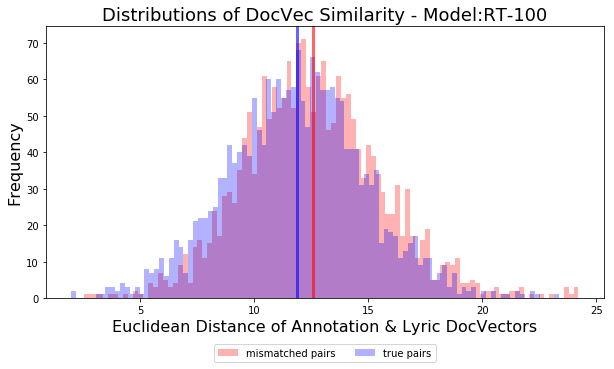

In [179]:
tru_pairs = train_true_ed
non_pairs = train_false_ed

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

ax.set_title("Distributions of DocVec Similarity - Model:RT-100", fontsize=18)

plt.hist(non_pairs, bins=100, color='red', alpha=0.3, label='mismatched pairs')
plt.hist(tru_pairs, bins=100, color='blue', alpha=0.3, label='true pairs')

plt.axvline(x=tru_pairs.mean(), c='blue', alpha=0.6, linewidth=3)
plt.axvline(x=non_pairs.mean(), c='red', alpha=0.6, linewidth=3)
# plt.axhline(y=0, c='red', alpha=0.3)

ax.set_xlabel('Euclidean Distance of Annotation & Lyric DocVectors', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)

ax.legend(loc='upper center', ncol=2, markerscale=0.5, bbox_to_anchor=(0.5, -0.15))

plt.show()

fig.savefig('../data/ed_dist_rt100.png')

In [180]:
test_pairs = rt_base.tst_pairings_df

test_true_ed = test_pairs[test_pairs['is_pair'] == 1]['pair_ed']
test_false_ed = test_pairs[test_pairs['is_pair'] == 0]['pair_ed']

stat, p = ttest_ind(test_true_ed, test_false_ed)

print(stat)
print(p)

-4.634211863387714
4.048693439266282e-06


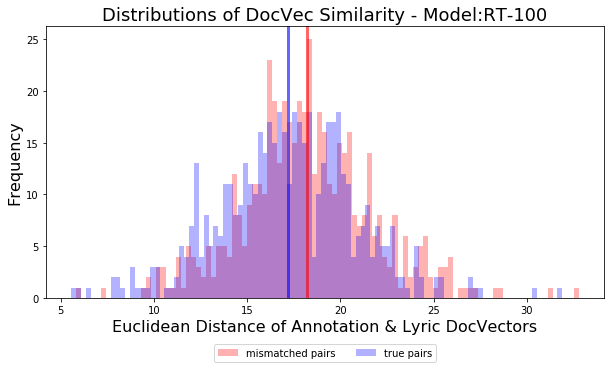

In [182]:
tru_pairs = test_true_ed
non_pairs = test_false_ed

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

ax.set_title("Distributions of DocVec Similarity - Model:RT-100", fontsize=18)

plt.hist(non_pairs, bins=100, color='red', alpha=0.3, label='mismatched pairs')
plt.hist(tru_pairs, bins=100, color='blue', alpha=0.3, label='true pairs')

plt.axvline(x=tru_pairs.mean(), c='blue', alpha=0.6, linewidth=3)
plt.axvline(x=non_pairs.mean(), c='red', alpha=0.6, linewidth=3)
# plt.axhline(y=0, c='red', alpha=0.3)

ax.set_xlabel('Euclidean Distance of Annotation & Lyric DocVectors', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)

ax.legend(loc='upper center', ncol=2, markerscale=0.5, bbox_to_anchor=(0.5, -0.15))

plt.show()

fig.savefig('../data/test_ed_dist_rt100.png')

In [185]:
train_pairs = rt_base.tr_pairings_df

train_true_ed = train_pairs[train_pairs['is_pair'] == 1]['pair_ed']
train_true_cs = train_pairs[train_pairs['is_pair'] == 1]['pair_cs']

train_false_ed = train_pairs[train_pairs['is_pair'] == 0]['pair_ed']
train_false_cs = train_pairs[train_pairs['is_pair'] == 0]['pair_cs']

# train_pairs[['is_pair', 'pair_ed', 'pair_cs']]

,is_pair,pair_ed,pair_cs
0,1,12.019732,0.394200
1,1,9.113456,0.476986
2,1,8.909910,0.238958
3,1,12.274139,0.360723
4,1,17.792145,0.173270
5,1,14.931053,0.273976
6,1,14.174185,0.491680
7,1,14.346421,0.045320
8,1,13.004703,0.379786
9,1,10.951710,0.369235


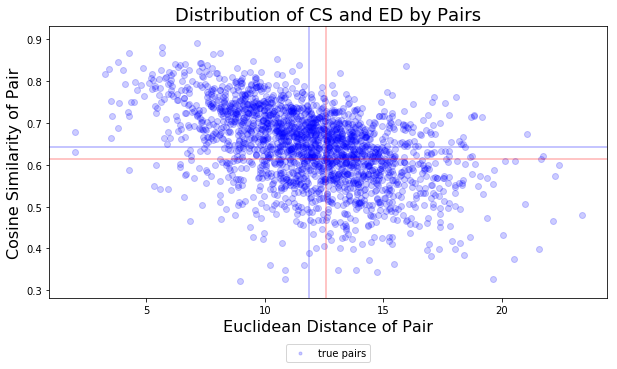

In [197]:
x0 = train_false_ed
y0 = train_false_cs
x1 = train_true_ed
y1 = train_true_cs

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_title("Distribution of CS and ED by Pairs", fontsize=18)

ax.scatter(x1, y1, alpha=0.2, c='blue', label='true pairs')
# ax.scatter(x0, y0, alpha=0.2, c='red', label='false pairs')
# ax.scatter(x1, y1, alpha=0.2, c='blue', label='true pairs')

plt.axvline(x=train_true_ed.mean(), c='blue', alpha=0.3)
plt.axvline(x=train_false_ed.mean(), c='red', alpha=0.3)
plt.axhline(y=train_true_cs.mean(), c='blue', alpha=0.3)
plt.axhline(y=train_false_cs.mean(), c='red', alpha=0.3)

# plt.plot(data[:,0], m*data[:,0] + b,color='red',label='Our Fitting Line')
ax.set_xlabel('Euclidean Distance of Pair', fontsize=16)
ax.set_ylabel('Cosine Similarity of Pair', fontsize=16)
ax.legend(loc='upper center', ncol=2, markerscale=0.5, bbox_to_anchor=(0.5, -0.15))

plt.show()

fig.savefig('cs_ed_comparison_true.png')

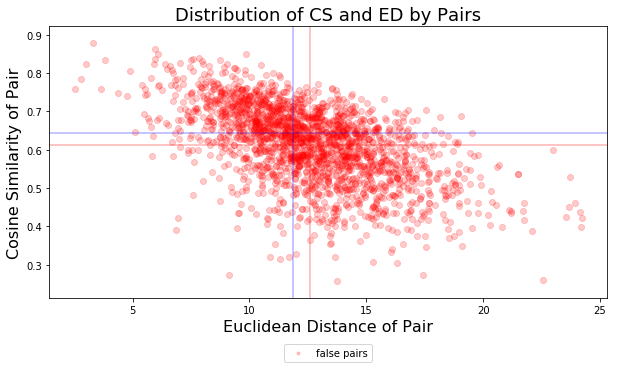

In [198]:
x0 = train_false_ed
y0 = train_false_cs
x1 = train_true_ed
y1 = train_true_cs

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_title("Distribution of CS and ED by Pairs", fontsize=18)

# ax.scatter(x1, y1, alpha=0.2, c='blue', label='true pairs')
ax.scatter(x0, y0, alpha=0.2, c='red', label='false pairs')
# ax.scatter(x1, y1, alpha=0.2, c='blue', label='true pairs')

plt.axvline(x=train_true_ed.mean(), c='blue', alpha=0.3)
plt.axvline(x=train_false_ed.mean(), c='red', alpha=0.3)
plt.axhline(y=train_true_cs.mean(), c='blue', alpha=0.3)
plt.axhline(y=train_false_cs.mean(), c='red', alpha=0.3)

ax.set_xlabel('Euclidean Distance of Pair', fontsize=16)
ax.set_ylabel('Cosine Similarity of Pair', fontsize=16)
ax.legend(loc='upper center', ncol=2, markerscale=0.5, bbox_to_anchor=(0.5, -0.15))

plt.show()

fig.savefig('cs_ed_comparison_false.png')

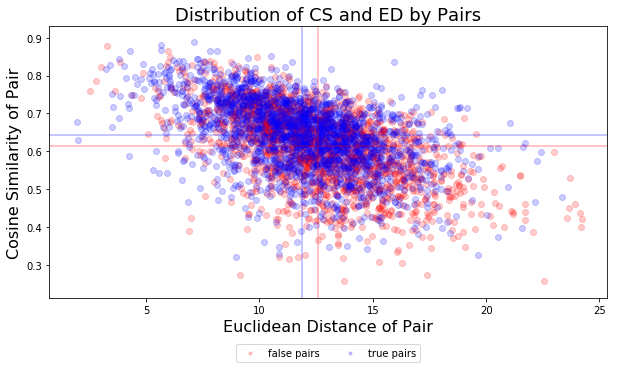

In [199]:
x0 = train_false_ed
y0 = train_false_cs
x1 = train_true_ed
y1 = train_true_cs

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_title("Distribution of CS and ED by Pairs", fontsize=18)

# ax.scatter(x1, y1, alpha=0.2, c='blue', label='true pairs')
ax.scatter(x0, y0, alpha=0.2, c='red', label='false pairs')
ax.scatter(x1, y1, alpha=0.2, c='blue', label='true pairs')

plt.axvline(x=train_true_ed.mean(), c='blue', alpha=0.3)
plt.axvline(x=train_false_ed.mean(), c='red', alpha=0.3)
plt.axhline(y=train_true_cs.mean(), c='blue', alpha=0.3)
plt.axhline(y=train_false_cs.mean(), c='red', alpha=0.3)

# plt.plot(data[:,0], m*data[:,0] + b,color='red',label='Our Fitting Line')
ax.set_xlabel('Euclidean Distance of Pair', fontsize=16)
ax.set_ylabel('Cosine Similarity of Pair', fontsize=16)
ax.legend(loc='upper center', ncol=2, markerscale=0.5, bbox_to_anchor=(0.5, -0.15))

plt.show()

fig.savefig('cs_ed_comparison_both.png')

In [75]:
train_true_cs = train_pairs[train_pairs['is_pair'] == 1]['pair_cs']
train_false_cs = train_pairs[train_pairs['is_pair'] == 0]['pair_cs']

print(len(train_true_cs))
print(len(train_false_cs))

print(train_true_cs.mean())
print(train_false_cs.mean())

2033
2033
0.31309721139612373
0.2097007596372378


In [76]:
from scipy.stats import ttest_ind

stat, p = ttest_ind(train_true_cs, train_false_cs)

print(stat)
print(p)

28.862170922113464
8.570587921795706e-167


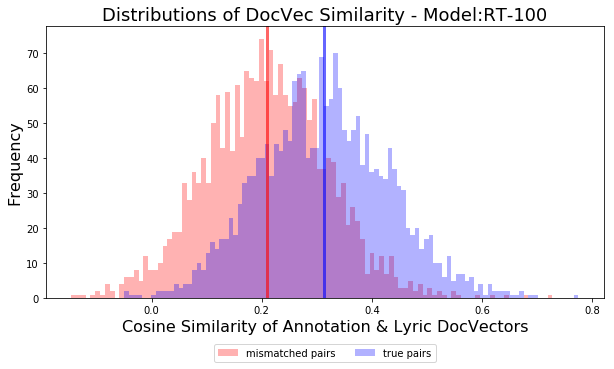

In [84]:
tru_pairs = train_true_cs
non_pairs = train_false_cs

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

ax.set_title("Distributions of DocVec Similarity - Model:RT-100", fontsize=18)

plt.hist(non_pairs, bins=100, color='red', alpha=0.3, label='mismatched pairs')
plt.hist(tru_pairs, bins=100, color='blue', alpha=0.3, label='true pairs')

plt.axvline(x=tru_pairs.mean(), c='blue', alpha=0.6, linewidth=3)
plt.axvline(x=non_pairs.mean(), c='red', alpha=0.6, linewidth=3)
# plt.axhline(y=0, c='red', alpha=0.3)

ax.set_xlabel('Cosine Similarity of Annotation & Lyric DocVectors', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)

ax.legend(loc='upper center', ncol=2, markerscale=0.5, bbox_to_anchor=(0.5, -0.15))

plt.show()

# fig.savefig('../data/cs_dist_rt100.png')

In [69]:
rt_base.tr_pairings_df.head()

,ref_id,tate_id,ref_artist,tate_artist,ref_in_train,tate_in_train,ref_doc_id,tate_doc_id,ref_raw_text,tate_raw_text,ref_pp_text,tate_pp_text,is_pair,same_artist,ref_vecs,tate_vecs,pair_cs,pair_ed
0,2552277,2552277,Beyoncé,Beyoncé,True,True,0,0,I can't wait 'til I get home so you can tear t...,Bey can’t wait to get home so she can material...,"[i, can't, wait, 'til, i, get, home, so, you, ...","[bey, can’t, wait, to, get, home, so, she, can...",1,1,"[[-2.215963], [0.14202432], [0.22570793], [0.0...","[[-1.7102143], [-0.13793725], [0.66885656], [0...",0.394200,12.019732
1,2233756,2233756,Drake,Drake,True,True,1,1,"Big time\n Sunshine,",Stunnaman dropping some more references – firs...,"[big, time, \n, sunshine, ,]","[stunnaman, dropping, some, more, references, ...",1,1,"[[-0.010889866], [0.1997664], [0.0034176647], ...","[[-1.6884965], [1.9686725], [1.3010232], [1.60...",0.476986,9.113456
2,5029023,5029023,J. Cole,J. Cole,True,True,2,2,Out in Hollywood bringin' back five or six hoe...,Birds will always stay around as long as you h...,"[out, in, hollywood, bringin', back, five, or,...","[birds, will, always, stay, around, as, long, ...",1,1,"[[0.027535014], [-0.25227487], [-1.5752109], [...","[[-0.31252304], [0.41632763], [-0.93187267], [...",0.238958,8.909910
3,8663001,8663001,Kanye West,Kanye West,True,True,3,3,I was high when I met her\n We was down in Tri...,Around the time Kanye and Kim started dating i...,"[i, was, high, when, i, met, her, \n, we, was,...","[around, the, time, kanye, and, kim, started, ...",1,1,"[[-0.17094713], [-0.6886978], [0.10283382], [0...","[[-1.464015], [-0.62226486], [2.3277814], [-0....",0.360723,12.274139
4,12365147,12365147,JAY-Z,JAY-Z,True,True,4,4,And all this ratchet shit and we more expansiv...,As JAY-Z and Beyoncé’s relationship progressed...,"[and, all, this, ratchet, shit, and, we, more,...","[as, jay, -, z, and, beyoncé’s, relationship, ...",1,1,"[[0.70883], [-0.61437607], [-0.5639689], [0.07...","[[0.88517946], [-0.49163005], [1.7149482], [0....",0.173270,17.792145


In [70]:
rt_base.calculate_pair_sims_array(test_pairings_df, is_train=False)
print(rt_base.tst_pairings_stats)

{'avg_tru': 0.16287587612111684, 'avg_false': 0.04747081119833143, 'max_tru': 0.6792542338371277, 'max_false': 0.3974694013595581, 'min_tru': -0.23111394047737122, 'min_false': -0.20153257250785828}


In [80]:
test_pairs = rt_base.tst_pairings_df
print(test_pairs.shape)
print(test_pairs[test_pairs['is_pair'] == 1].shape)
print(test_pairs[test_pairs['is_pair'] == 0].shape)

test_true_cs = test_pairs[test_pairs['is_pair'] == 1]['pair_cs']
test_false_cs = test_pairs[test_pairs['is_pair'] == 0]['pair_cs']

print(len(test_true_cs))
print(len(test_false_cs))

print(test_true_cs.mean())
print(test_false_cs.mean())

(1018, 18)
(509, 18)
(509, 18)
509
509
0.16287587612111684
0.04747081119833143


In [81]:
stat, p = ttest_ind(test_true_cs, test_false_cs)

print(stat)
print(p)

14.914347990597278
1.2336916480879096e-45


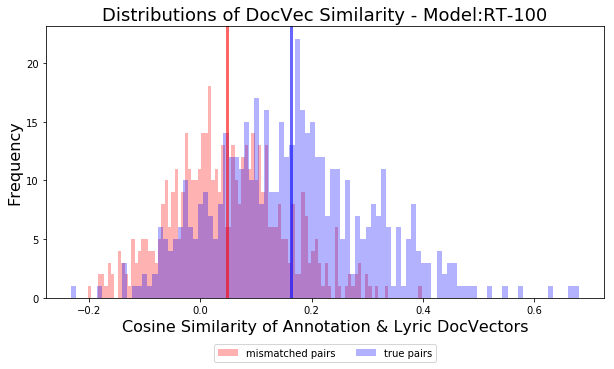

In [83]:
tru_pairs = test_true_cs
non_pairs = test_false_cs

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

ax.set_title("Distributions of DocVec Similarity - Model:RT-100", fontsize=18)

plt.hist(non_pairs, bins=100, color='red', alpha=0.3, label='mismatched pairs')
plt.hist(tru_pairs, bins=100, color='blue', alpha=0.3, label='true pairs')

plt.axvline(x=tru_pairs.mean(), c='blue', alpha=0.6, linewidth=3)
plt.axvline(x=non_pairs.mean(), c='red', alpha=0.6, linewidth=3)
# plt.axhline(y=0, c='red', alpha=0.3)

ax.set_xlabel('Cosine Similarity of Annotation & Lyric DocVectors', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)

ax.legend(loc='upper center', ncol=2, markerscale=0.5, bbox_to_anchor=(0.5, -0.15))

plt.show()

# fig.savefig('../data/test_cs_dist_rt100.png')

In [135]:
rt_base_tr = rt_base.tr_pairings_df
rt_base_tr[rt_base_tr['pair_cs'] == rt_base_tr['pair_cs'].max()]

best_ref_rt_base = rt_base_tr[rt_base_tr['pair_cs'] == rt_base_tr['pair_cs'].max()]['ref_raw_text']
best_ref_idx_rt_base = best_ref_rt_base.index[0]
best_ref_txt_rt_base = best_ref_rt_base[best_ref_idx_rt_base]
print("BEST REF:")
print(best_ref_txt_rt_base)

best_tate_rt_base = rt_base_tr[rt_base_tr['pair_cs'] == rt_base_tr['pair_cs'].max()]['tate_raw_text']
best_tate_idx_rt_base = best_tate_rt_base.index[0]
best_tate_txt_rt_base = best_tate_rt_base[best_tate_idx_rt_base]
print("\nBEST TATE:")
print(best_tate_txt_rt_base)

rt_base_tr = rt_base.tr_pairings_df
t_pairs = rt_base_tr[rt_base_tr['is_pair'] == 1]
t_pairs[t_pairs['pair_cs'] == t_pairs['pair_cs'].min()]

worst_ref_rt_base = t_pairs[t_pairs['pair_cs'] == t_pairs['pair_cs'].min()]['ref_raw_text']
worst_ref_idx_rt_base = worst_ref_rt_base.index[0]
worst_ref_txt_rt_base = worst_ref_rt_base[worst_ref_idx_rt_base]
print("\nWORST REF:")
print(worst_ref_txt_rt_base)

worst_tate_rt_base = t_pairs[t_pairs['pair_cs'] == t_pairs['pair_cs'].min()]['tate_raw_text']
worst_tate_idx_rt_base = worst_tate_rt_base.index[0]
worst_tate_txt_rt_base = worst_tate_rt_base[worst_tate_idx_rt_base]
print("\nWORST TATE:")
print(worst_tate_txt_rt_base)

BEST REF:
Gone

BEST TATE:
Lil Wayne is So Gone

WORST REF:
Please face me when I speak
 Please say to me somethin' before you leave
 You've been treatin' me like I'm invisible, now I'm visible to you
 Oh, the invisible truths they sold
 I can't quite understand the games you play

WORST TATE:
One of the common gripes associated with spirituality is the inability to converse with the higher power. In this case dealing with Christianity, Sampha remarks that God is not responding to his prayers; God is not acknowledging his existence.

Sampha then realizes however, as his verse progresses (or perhaps as time progresses), that God does respond to him — albeit in a way that cannot be understood.


In [141]:
rt_base.tst_pairings_df[rt_base.tst_pairings_df['ref_id'] == 8828663]

,ref_id,tate_id,ref_artist,tate_artist,ref_in_train,tate_in_train,ref_doc_id,tate_doc_id,ref_raw_text,tate_raw_text,ref_pp_text,tate_pp_text,is_pair,same_artist,ref_vecs,tate_vecs,pair_cs,pair_ed
192,8828663,8828663,Eminem,Eminem,False,False,192,192,Where's my snare?\n I have no snare in my head...,This was true. I was recording and couldn’t he...,"[where's, my, snare, ?, \n, i, have, no, snare...","[this, was, true, ., i, was, recording, and, c...",1,1,"[[-0.08219717], [-0.08365493], [-0.07361332], ...","[[0.8977836], [-2.0895288], [0.34850293], [0.5...",0.124557,12.060094
556,8828663,7618848,Eminem,Drake,False,False,192,422,Where's my snare?\n I have no snare in my head...,Correcton for line 3 in the first Hook 1:\n\n“...,"[where's, my, snare, ?, \n, i, have, no, snare...","[correcton, for, line, 3, in, the, first, hook...",0,0,"[[-0.051664382], [-0.14005633], [-0.027646566]...","[[0.58029157], [-2.1819148], [-2.236305], [-0....",0.131028,14.641675


In [142]:
rt_base.tst_pairings_df[rt_base.tst_pairings_df['tate_id'] == 8828663]

,ref_id,tate_id,ref_artist,tate_artist,ref_in_train,tate_in_train,ref_doc_id,tate_doc_id,ref_raw_text,tate_raw_text,ref_pp_text,tate_pp_text,is_pair,same_artist,ref_vecs,tate_vecs,pair_cs,pair_ed
192,8828663,8828663,Eminem,Eminem,False,False,192,192,Where's my snare?\n I have no snare in my head...,This was true. I was recording and couldn’t he...,"[where's, my, snare, ?, \n, i, have, no, snare...","[this, was, true, ., i, was, recording, and, c...",1,1,"[[-0.08219717], [-0.08365493], [-0.07361332], ...","[[0.8977836], [-2.0895288], [0.34850293], [0.5...",0.124557,12.060094
977,16278952,8828663,Ariana Grande,Eminem,False,False,499,192,Girls with tattoos who like getting in trouble,This was true. I was recording and couldn’t he...,"[girls, with, tattoos, who, like, getting, in,...","[this, was, true, ., i, was, recording, and, c...",0,0,"[[-0.33165905], [0.017958796], [0.6839597], [0...","[[1.106667], [-1.8313242], [0.45347005], [0.46...",-0.070270,15.115622


In [171]:
rt_base.tr_pairings_df[rt_base.tr_pairings_df['ref_id'] == 9224654]

,ref_id,tate_id,ref_artist,tate_artist,ref_in_train,tate_in_train,ref_doc_id,tate_doc_id,ref_raw_text,tate_raw_text,ref_pp_text,tate_pp_text,is_pair,same_artist,ref_vecs,tate_vecs,pair_cs,pair_ed
1969,9224654,9224654,Eminem,Eminem,True,True,1969,1969,"Go call you a lawyer, file you a lawsuit\n I'l...",Every time I have had a court issue since this...,"[go, call, you, a, lawyer, ,, file, you, a, la...","[every, time, i, have, had, a, court, issue, s...",1,1,"[[-0.5918145], [0.24630795], [-0.6943151], [-0...","[[-0.9912901], [-0.19398649], [-0.5825204], [-...",0.23619,9.022890
2433,9224654,9245893,Eminem,Original Broadway Cast of Hamilton,True,True,1969,1530,"Go call you a lawyer, file you a lawsuit\n I'l...",This is the first instance of Eliza’s “enough”...,"[go, call, you, a, lawyer, ,, file, you, a, la...","[this, is, the, first, instance, of, eliza’s, ...",0,0,"[[-0.5025801], [0.1695243], [-0.8081066], [-0....","[[2.3788755], [-1.440339], [-1.3304251], [-1.3...",-0.02965,19.524828


In [172]:
rt_base.tr_pairings_df[rt_base.tr_pairings_df['tate_id'] == 9224654]

,ref_id,tate_id,ref_artist,tate_artist,ref_in_train,tate_in_train,ref_doc_id,tate_doc_id,ref_raw_text,tate_raw_text,ref_pp_text,tate_pp_text,is_pair,same_artist,ref_vecs,tate_vecs,pair_cs,pair_ed
1969,9224654,9224654,Eminem,Eminem,True,True,1969,1969,"Go call you a lawyer, file you a lawsuit\n I'l...",Every time I have had a court issue since this...,"[go, call, you, a, lawyer, ,, file, you, a, la...","[every, time, i, have, had, a, court, issue, s...",1,1,"[[-0.5918145], [0.24630795], [-0.6943151], [-0...","[[-0.9912901], [-0.19398649], [-0.5825204], [-...",0.23619,9.022890
3697,5203239,9224654,The Weeknd,Eminem,True,True,1361,1969,"Only you to trust, only you",Every time I have had a court issue since this...,"[only, you, to, trust, ,, only, you]","[every, time, i, have, had, a, court, issue, s...",0,0,"[[-0.0053423545], [-0.19551039], [-0.46532398]...","[[-0.9240946], [0.0144540435], [-0.59645075], ...",0.35322,7.752593


In [ ]:
rt_base.tr_pairings_df[rt_base.tr_pairings_df['ref_id'] == 9224654]
rt_base.tr_pairings_df[rt_base.tr_pairings_df['tate_id'] == 9224654]

In [71]:
rt_base.tst_pairings_df.head()

,ref_id,tate_id,ref_artist,tate_artist,ref_in_train,tate_in_train,ref_doc_id,tate_doc_id,ref_raw_text,tate_raw_text,ref_pp_text,tate_pp_text,is_pair,same_artist,ref_vecs,tate_vecs,pair_cs,pair_ed
0,348287,348287,J. Cole,J. Cole,False,False,0,0,"Man, that thing in them jeans too fat for her\...",Could mean two things:\n\n\nHer ass is large e...,"[man, ,, that, thing, in, them, jeans, too, fa...","[could, mean, two, things, \n\n\n, her, ass, i...",1,1,"[[1.40892], [0.37519544], [0.2118066], [1.5881...","[[0.7954885], [0.84162074], [1.2058268], [-0.3...",0.459197,12.814795
1,2558029,2558029,Beyoncé,Beyoncé,False,False,1,1,"High like treble, pumping on the mids",Treble is a sound of high frequency. Bey uses ...,"[high, like, treble, ,, pumping, on, the, mids]","[treble, is, a, sound, of, high, frequency, .,...",1,1,"[[-0.7745775], [-0.10311797], [-0.05210088], [...","[[-0.3759288], [0.9475863], [0.5015093], [2.29...",0.378476,12.567392
2,2397113,2397113,Eminem,Eminem,False,False,2,2,Say what I wanna say to the kid that said that...,He wanted to be able to vent his frustration a...,"[say, what, i, wanna, say, to, the, kid, that,...","[he, wanted, to, be, able, to, vent, his, frus...",1,1,"[[0.2616795], [0.13811457], [0.77182645], [-0....","[[2.174087], [1.066996], [-1.3011353], [0.1279...",0.174469,15.138635
3,4864874,4864874,Eminem,Eminem,False,False,3,3,"Feels like a close, it's coming to\n Fuck am I...","In this line, after all he has been through, a...","[feels, like, a, close, ,, it's, coming, to, \...","[in, this, line, ,, after, all, he, has, been,...",1,1,"[[-0.97093606], [1.4866129], [1.2665232], [-0....","[[-0.89343446], [-1.8396271], [-0.56738514], [...",0.148475,15.598763
4,14385244,14385244,J. Cole,J. Cole,False,False,4,4,Some niggas graduated to powder\n I dabble lat...,Weed is often referred to as a “gateway drug” ...,"[some, niggas, graduated, to, powder, \n, i, d...","[weed, is, often, referred, to, as, a, “, gate...",1,1,"[[0.10272967], [1.2431799], [0.1349197], [0.61...","[[-1.5266764], [-0.8185423], [0.47695574], [2....",0.101114,16.814390


In [ ]:
from scipy.stats import ttest_ind
stat, p = ttest_ind(tru_pairs, non_pairs)

print(stat)
print(p)

In [94]:
rt_50 = Doc2VecModeler('rt_50', rt_train_pcorpus, 'rt_train', vector_size=50)
rt_50.fit_model(verbose=True)
pass_se = rt_50.calc_self_recognition_ability()
print(pass_se)
print(rt_50.self_recog_rate)
print(rt_50.greater_than_95)

Model training complete!
True
0.9918839153959665
True


In [95]:
rt_50.calculate_pair_sims_array(train_pairings_df, is_train=True)
print(rt_50.tr_pairings_stats)

{'avg_tru': 0.3304039905164061, 'avg_false': 0.19711450572069839, 'max_tru': 0.7800467610359192, 'max_false': 0.7247883677482605, 'min_tru': -0.13514776527881622, 'min_false': -0.2582402527332306}


In [96]:
train_pairs = rt_50.tr_pairings_df
print(train_pairs.shape)
print(train_pairs[train_pairs['is_pair'] == 1].shape)
print(train_pairs[train_pairs['is_pair'] == 0].shape)

train_true_cs = train_pairs[train_pairs['is_pair'] == 1]['pair_cs']
train_false_cs = train_pairs[train_pairs['is_pair'] == 0]['pair_cs']

print(len(train_true_cs))
print(len(train_false_cs))

print(train_true_cs.mean())
print(train_false_cs.mean())

stat, p = ttest_ind(train_true_cs, train_false_cs)

print(stat)
print(p)

(4066, 18)
(2033, 18)
(2033, 18)
2033
2033
0.3304039905164061
0.19711450572069839
31.576980093427814
6.561574544790577e-196


In [111]:
rt_50_tr = rt_50.tr_pairings_df
rt_50_tr[rt_50_tr['pair_cs'] == rt_50_tr['pair_cs'].max()]

,ref_id,tate_id,ref_artist,tate_artist,ref_in_train,tate_in_train,ref_doc_id,tate_doc_id,ref_raw_text,tate_raw_text,ref_pp_text,tate_pp_text,is_pair,same_artist,ref_vecs,tate_vecs,pair_cs,pair_ed
1795,13253011,13253011,XXXTENTACION,XXXTENTACION,True,True,1795,1795,"Just like a gnome, I'm at your home\n Right on...",Gnomes are garden accesories that people put o...,"[just, like, a, gnome, ,, i'm, at, your, home,...","[gnomes, are, garden, accesories, that, people...",1,1,"[[-0.71309596], [0.2867714], [0.059041217], [-...","[[-0.9406412], [0.39319274], [0.32920846], [1....",0.780047,5.737091


In [125]:
best_ref_rt50 = rt_50_tr[rt_50_tr['pair_cs'] == rt_50_tr['pair_cs'].max()]['ref_raw_text']
best_ref_idx_rt50 = best_ref_rt50.index[0]
best_ref_txt_rt50 = best_ref_rt50[best_ref_idx_rt50]
best_ref_txt_rt50

"Just like a gnome, I'm at your home\n Right on your yard,"

In [126]:
best_tate_rt50 = rt_50_tr[rt_50_tr['pair_cs'] == rt_50_tr['pair_cs'].max()]['tate_raw_text']
best_tate_idx_rt50 = best_tate_rt50.index[0]
best_tate_txt_rt50 = best_tate_rt50[best_tate_idx_rt50]
best_tate_txt_rt50

'Gnomes are garden accesories that people put outside on their lawn for decoration. Here X states that similar to a gnome, he’s outside standing on your lawn.\n\n\n\nX also used this line in “Ghost Busters”\n\nJust like a gnome, I’m at your home, Right on your yard, pulling your card'

In [127]:
rt_50_tr = rt_50.tr_pairings_df
rt_50_tr[rt_50_tr['pair_cs'] == rt_50_tr['pair_cs'].min()]

,ref_id,tate_id,ref_artist,tate_artist,ref_in_train,tate_in_train,ref_doc_id,tate_doc_id,ref_raw_text,tate_raw_text,ref_pp_text,tate_pp_text,is_pair,same_artist,ref_vecs,tate_vecs,pair_cs,pair_ed
2340,11141972,8418062,J. Cole,Original Broadway Cast of Hamilton,True,True,1211,773,"She fuck with small town niggas, I got bigger ...","Comparing this to Burr’s subsequent line, “I’l...","[she, fuck, with, small, town, niggas, ,, i, g...","[comparing, this, to, burr’s, subsequent, line...",0,0,"[[-1.6835338], [0.5146382], [-0.06486031], [0....","[[0.0038436558], [2.9056528], [1.3334453], [-3...",-0.25824,23.023327


In [128]:
worst_ref_rt50 = rt_50_tr[rt_50_tr['pair_cs'] == rt_50_tr['pair_cs'].min()]['ref_raw_text']
worst_ref_idx_rt50 = worst_ref_rt50.index[0]
worst_ref_txt_rt50 = worst_ref_rt50[worst_ref_idx_rt50]
worst_ref_txt_rt50

'She fuck with small town niggas, I got bigger dreams\n She fuck with small town niggas, I got bigger dreams (listen)\n She fuck with small town niggas, I got bigger dreams\n She fuck with small town niggas, I got bigger dreams (listen)'

In [129]:
worst_tate_rt50 = rt_50_tr[rt_50_tr['pair_cs'] == rt_50_tr['pair_cs'].min()]['tate_raw_text']
worst_tate_idx_rt50 = worst_tate_rt50.index[0]
worst_tate_txt_rt50 = worst_tate_rt50[worst_tate_idx_rt50]
worst_tate_txt_rt50

'Comparing this to Burr’s subsequent line, “I’ll make a million mistakes”, it is interesting to see what each father promises to their child and how it reflects on their personal belief systems.\n\nHamilton says how he will do whatever it takes, showing Hamilton’s brash personality and how he is willing to “always say what he believes”.\n\nBurr says how he will make a million mistakes, showing Burr’s cautious, calculated, and almost wish-washy stance on ideas and how he will “wait here and see which way the wind will blow”.'

In [130]:
rt_50_tr = rt_50.tr_pairings_df
t_pairs = rt_50_tr[rt_50_tr['is_pair'] == 1]
t_pairs[t_pairs['pair_cs'] == t_pairs['pair_cs'].min()]

,ref_id,tate_id,ref_artist,tate_artist,ref_in_train,tate_in_train,ref_doc_id,tate_doc_id,ref_raw_text,tate_raw_text,ref_pp_text,tate_pp_text,is_pair,same_artist,ref_vecs,tate_vecs,pair_cs,pair_ed
249,4981981,4981981,Drake,Drake,True,True,249,249,I'm turnin' into a nigga that thinks about mon...,Conventional grammar structures usually prescr...,"[i'm, turnin', into, a, nigga, that, thinks, a...","[conventional, grammar, structures, usually, p...",1,1,"[[-2.7715127], [-1.4980116], [-2.1184704], [-1...","[[1.1379219], [1.1931294], [-0.95300454], [0.1...",-0.135148,14.618474


In [131]:
worst_ref_rt50 = t_pairs[t_pairs['pair_cs'] == t_pairs['pair_cs'].min()]['ref_raw_text']
worst_ref_idx_rt50 = worst_ref_rt50.index[0]
worst_ref_txt_rt50 = worst_ref_rt50[worst_ref_idx_rt50]
worst_ref_txt_rt50

"I'm turnin' into a nigga that thinks about money and women\n Like 24/7, that's where my life took me\n That's just how shit happened to go\n Yeah, and you know\n Runnin' through the 6 with my, with my"

In [132]:
worst_tate_rt50 = t_pairs[t_pairs['pair_cs'] == t_pairs['pair_cs'].min()]['tate_raw_text']
worst_tate_idx_rt50 = worst_tate_rt50.index[0]
worst_tate_txt_rt50 = worst_tate_rt50[worst_tate_idx_rt50]
worst_tate_txt_rt50

'Conventional grammar structures usually prescribe the use of “that” in relation to objects, not people. Drake’s choice of the word “that” instead of the word “who” could indicate that he considers his constant preoccupation with “money and women” a negative trait, perhaps even something subhuman.'

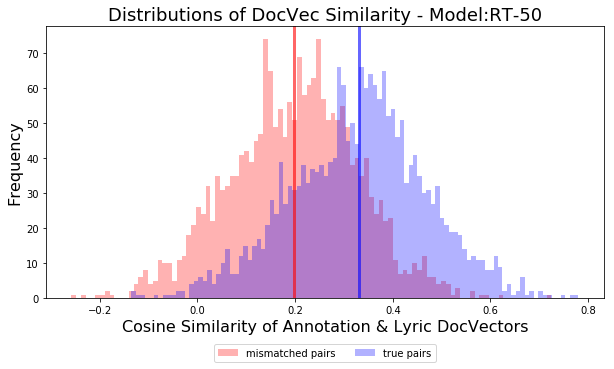

In [101]:
tru_pairs = train_true_cs
non_pairs = train_false_cs

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

ax.set_title("Distributions of DocVec Similarity - Model:RT-50", fontsize=18)

plt.hist(non_pairs, bins=100, color='red', alpha=0.3, label='mismatched pairs')
plt.hist(tru_pairs, bins=100, color='blue', alpha=0.3, label='true pairs')

plt.axvline(x=tru_pairs.mean(), c='blue', alpha=0.6, linewidth=3)
plt.axvline(x=non_pairs.mean(), c='red', alpha=0.6, linewidth=3)
# plt.axhline(y=0, c='red', alpha=0.3)

ax.set_xlabel('Cosine Similarity of Annotation & Lyric DocVectors', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)

ax.legend(loc='upper center', ncol=2, markerscale=0.5, bbox_to_anchor=(0.5, -0.15))

plt.show()

fig.savefig('../data/cs_dist_rt50.png')

In [98]:
rt_50.calculate_pair_sims_array(test_pairings_df, is_train=False)
print(rt_50.tst_pairings_stats)

{'avg_tru': 0.18837317575923349, 'avg_false': 0.06860896905523693, 'max_tru': 0.7442008256912231, 'max_false': 0.5073787569999695, 'min_tru': -0.345293790102005, 'min_false': -0.37597233057022095}


In [99]:
test_pairs = rt_50.tst_pairings_df
print(test_pairs.shape)
print(test_pairs[test_pairs['is_pair'] == 1].shape)
print(test_pairs[test_pairs['is_pair'] == 0].shape)

test_true_cs = test_pairs[test_pairs['is_pair'] == 1]['pair_cs']
test_false_cs = test_pairs[test_pairs['is_pair'] == 0]['pair_cs']

print(len(test_true_cs))
print(len(test_false_cs))

print(test_true_cs.mean())
print(test_false_cs.mean())

stat, p = ttest_ind(test_true_cs, test_false_cs)

print(stat)
print(p)

(1018, 18)
(509, 18)
(509, 18)
509
509
0.18837317575923349
0.06860896905523693
12.19657293721642
4.977041140685429e-32


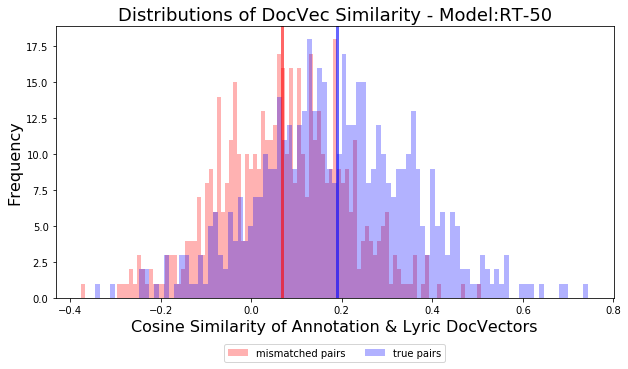

In [102]:
tru_pairs = test_true_cs
non_pairs = test_false_cs

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

ax.set_title("Distributions of DocVec Similarity - Model:RT-50", fontsize=18)

plt.hist(non_pairs, bins=100, color='red', alpha=0.3, label='mismatched pairs')
plt.hist(tru_pairs, bins=100, color='blue', alpha=0.3, label='true pairs')

plt.axvline(x=tru_pairs.mean(), c='blue', alpha=0.6, linewidth=3)
plt.axvline(x=non_pairs.mean(), c='red', alpha=0.6, linewidth=3)
# plt.axhline(y=0, c='red', alpha=0.3)

ax.set_xlabel('Cosine Similarity of Annotation & Lyric DocVectors', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)

ax.legend(loc='upper center', ncol=2, markerscale=0.5, bbox_to_anchor=(0.5, -0.15))

plt.show()

fig.savefig('../data/test_cs_dist_rt50.png')

In [103]:
rt_50t = Doc2VecModeler('rt_50t', rt_tagged_train_pcorpus, 'rt_tagged_train', vector_size=50)
rt_50t.fit_model(verbose=True)
pass_se = rt_50t.calc_self_recognition_ability()
print(pass_se)
print(rt_50t.self_recog_rate)
print(rt_50t.greater_than_95)

Model training complete!
False
0.03369404820462371
False


In [104]:
rt_50t.calculate_pair_sims_array(train_pairings_df, is_train=True)
print(rt_50t.tr_pairings_stats)

{'avg_tru': 0.6424560624276014, 'avg_false': 0.6133454337650136, 'max_tru': 0.8895692825317383, 'max_false': 0.878825843334198, 'min_tru': 0.32233408093452454, 'min_false': 0.2565697729587555}


In [105]:
train_pairs = rt_50t.tr_pairings_df
print(train_pairs.shape)
print(train_pairs[train_pairs['is_pair'] == 1].shape)
print(train_pairs[train_pairs['is_pair'] == 0].shape)

train_true_cs = train_pairs[train_pairs['is_pair'] == 1]['pair_cs']
train_false_cs = train_pairs[train_pairs['is_pair'] == 0]['pair_cs']

print(len(train_true_cs))
print(len(train_false_cs))

print(train_true_cs.mean())
print(train_false_cs.mean())

stat, p = ttest_ind(train_true_cs, train_false_cs)

print(stat)
print(p)

(4066, 18)
(2033, 18)
(2033, 18)
2033
2033
0.6424560624276014
0.6133454337650136
9.71656374216114
4.448295885913761e-22


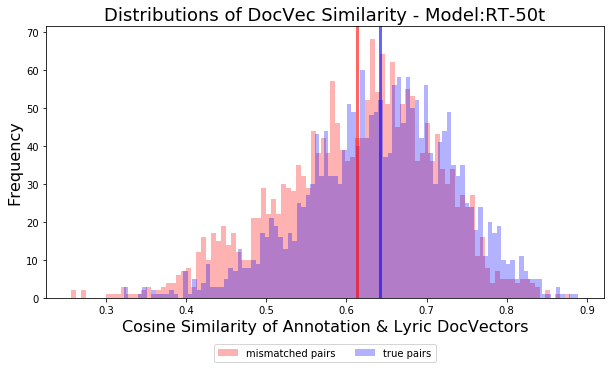

In [106]:
tru_pairs = train_true_cs
non_pairs = train_false_cs

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

ax.set_title("Distributions of DocVec Similarity - Model:RT-50t", fontsize=18)

plt.hist(non_pairs, bins=100, color='red', alpha=0.3, label='mismatched pairs')
plt.hist(tru_pairs, bins=100, color='blue', alpha=0.3, label='true pairs')

plt.axvline(x=tru_pairs.mean(), c='blue', alpha=0.6, linewidth=3)
plt.axvline(x=non_pairs.mean(), c='red', alpha=0.6, linewidth=3)
# plt.axhline(y=0, c='red', alpha=0.3)

ax.set_xlabel('Cosine Similarity of Annotation & Lyric DocVectors', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)

ax.legend(loc='upper center', ncol=2, markerscale=0.5, bbox_to_anchor=(0.5, -0.15))

plt.show()

# fig.savefig('../data/cs_dist_rt50t.png')

In [107]:
rt_50t.calculate_pair_sims_array(test_pairings_df, is_train=False)
print(rt_50t.tst_pairings_stats)

{'avg_tru': 0.3774019933190409, 'avg_false': 0.31342660518668336, 'max_tru': 0.8680666089057922, 'max_false': 0.6677205562591553, 'min_tru': -0.3627038300037384, 'min_false': -0.1731913834810257}


In [108]:
test_pairs = rt_50t.tst_pairings_df
print(test_pairs.shape)
print(test_pairs[test_pairs['is_pair'] == 1].shape)
print(test_pairs[test_pairs['is_pair'] == 0].shape)

test_true_cs = test_pairs[test_pairs['is_pair'] == 1]['pair_cs']
test_false_cs = test_pairs[test_pairs['is_pair'] == 0]['pair_cs']

print(len(test_true_cs))
print(len(test_false_cs))

print(test_true_cs.mean())
print(test_false_cs.mean())

stat, p = ttest_ind(test_true_cs, test_false_cs)

print(stat)
print(p)

(1018, 18)
(509, 18)
(509, 18)
509
509
0.3774019933190409
0.31342660518668336
6.912908379808826
8.376641610299311e-12


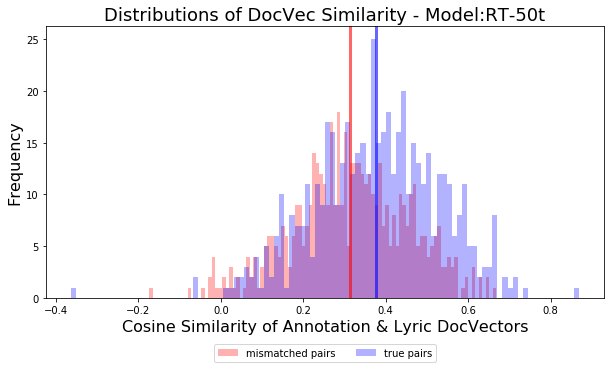

In [109]:
tru_pairs = test_true_cs
non_pairs = test_false_cs

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

ax.set_title("Distributions of DocVec Similarity - Model:RT-50t", fontsize=18)

plt.hist(non_pairs, bins=100, color='red', alpha=0.3, label='mismatched pairs')
plt.hist(tru_pairs, bins=100, color='blue', alpha=0.3, label='true pairs')

plt.axvline(x=tru_pairs.mean(), c='blue', alpha=0.6, linewidth=3)
plt.axvline(x=non_pairs.mean(), c='red', alpha=0.6, linewidth=3)
# plt.axhline(y=0, c='red', alpha=0.3)

ax.set_xlabel('Cosine Similarity of Annotation & Lyric DocVectors', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)

ax.legend(loc='upper center', ncol=2, markerscale=0.5, bbox_to_anchor=(0.5, -0.15))

plt.show()

# fig.savefig('../data/test_cs_dist_rt50t.png')